# Random-graph UD-MIS (Classical)

$$
H = -\sum_{i \in V} n_i + u \sum_{i,j \in E} n_i n_j
$$

Our goal is to find one of the ground state(s) - a solution to the UD-MIS problem - automatically through Monte Carlo sampling.

The probability distribution of the Ising model at temperature $T$ is given by the Gibbs distribution:

$$p(\sigma; T) = \frac{1}{Z(T)}\exp\left(-\frac{H(\sigma)}{T}\right)$$,

where $Z(T)$ is the normalization constant (also known as the *partition function*).

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from abstract_udmis import AbstractUDMIS

%matplotlib inline

Below you'll find code for the UDMIS model of interest. Strictly speaking, for the purposes of performing the Monte Carlo simulation we can simply compute the required energy differences using two calls to the energy function. However, we can often save significant computation time by writing a specialised function for the energy difference that avoids unnecessary calculations. Simply put, calculating the energy of a configuration of occupations requires you to iterate over all vertices in the graph, but the energy change associated with a single-occupation-flip can be computed just from values of the connected vertices.

In [21]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print("num_vertices:",self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)
    
    def mc_step(self, T):
        """Performs a full update of the Rydberg model using the Metropolis-Hastings algorithm"""
        current_energy = self.energy()
        for k in range(self.num_vertices):
            vertex = self.rand_vertex()
            dE = self.energy_diff(vertex)

            if (dE < 0) or (np.random.rand() < np.exp(-dE / T)): # Set the condition for acception or rejection
                current_energy += dE
                self.occupations[vertex] ^= 1 
                # flips occupation 0 --> 1 OR 1 --> 0
        return current_energy

In [161]:
def run_annealing(udmis, N=5000, verbose=True, plot_annealing=True, plot_occupation=True):

#     N = 5000
    t = np.arange(N+1)
    T_i = 100
    T_f = 0.01

    T = T_i * ((T_f/T_i) ** (t/N))

    temp_ = []
    E_ = []
    for t in range(N):
        # take a look at the abstract_udmis.py file to see how mc_step works
        temp = T[t]
        temp_.append(temp)
        E = udmis.mc_step(T=temp)
        E_.append(E)
        if verbose and t % 500 == 0:
            print(t, E)
    
    if plot_annealing:
        plt.figure(figsize = (10,3))
        ax = plt.subplot(1,1,1)
        plt.plot(temp_, E_)
        plt.xscale('log')
        ax.invert_xaxis()
        plt.xlabel('Temperature (K)')
        plt.ylabel('Energy')
        plt.title('Simulated Annealing')
        plt.show();
    
    
    if plot_occupation:
        occupation = udmis.occupations
        fig = plt.figure(figsize = (10,5))
        ax = fig.add_subplot(111, aspect =1)
        for i in range(len(graph)):
            x,y = graph[i]
            circle = plt.Circle((x,y), 0.5, edgecolor='black', alpha = 0.5,
                                facecolor='r' if occupation[i] else 'b',fill=True)
            ax.add_patch(circle)
            plt.text(x-0.08,y-0.05, i+1, fontsize=15)
        plt.title('Number of Vertices: {:d}\nSize of the MIS: {:d}'.format(len(graph),sum(occupation)))
        ax.autoscale()
        plt.show()
    
    return temp_, E_

num_vertices: 6
0 16.0
500 -1.0
1000 7.0
1500 -2.0
2000 -3.0
2500 -3.0
3000 -3.0
3500 -3
4000 -3
4500 -3


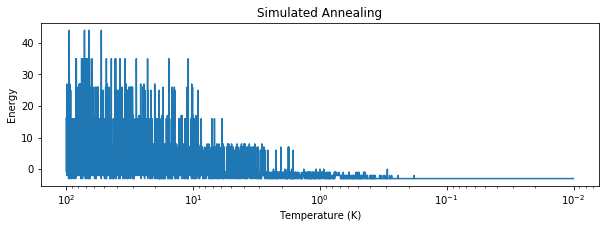

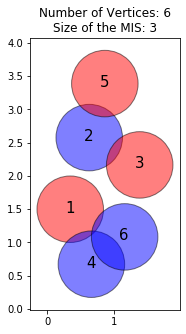

In [162]:
u = 10
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u, graph)
run_annealing(udmis);

## More complex graphs

num_vertices: 40
0 142.0
500 131.0
1000 4.0
1500 -3.0
2000 -11.0
2500 -15.0
3000 -18.0
3500 -19
4000 -19
4500 -19


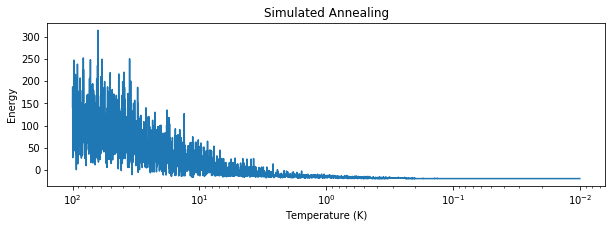

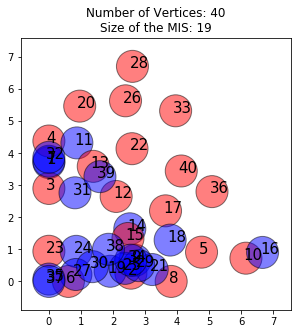

In [163]:
u = 10
# num_vertices = np.random.randint(1,15)
num_vertices = 40
graph = []
for i in range(num_vertices):
    graph.append((np.random.rand()*np.random.randint(8), np.random.rand()*np.random.randint(8)))
udmis = UDMIS(u, graph)
run_annealing(udmis);

# Task 3

num_vertices: 12
0 19.0
500 20.0
1000 21.0
1500 -3.0
2000 -3.0
2500 -4
3000 -5
3500 -5
4000 -5
4500 -5


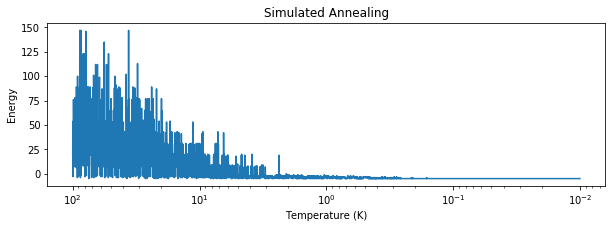

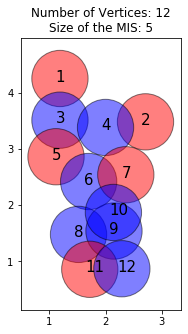

In [164]:
u = 12
graph = [(1.19, 4.25), 
         (2.71, 3.48), 
         (1.19, 3.51), 
         (2,3.38), 
         (1.12, 2.86), 
         (1.70, 2.42),
         (2.36, 2.54),
         (1.52, 1.48),
         (2.15, 1.54),
         (2.14, 1.87),
         (1.72, 0.86),
         (2.29, 0.87),
        ]

udmis = UDMIS(u, graph)
run_annealing(udmis);